### PyTorch tutorial 60 minutes blitz : 2) Vanilla Neural network

In [1]:
import torch

#### Autograd

If you set its attribute .requires_grad as True, it starts to track all operations on it. When you finish your computation you can call .backward() and have all the gradients computed automatically. The gradient for this tensor will be accumulated into .grad attribute.

To stop a tensor from tracking history, you can call .detach() to detach it from the computation history, and to prevent future computation from being tracked.

To prevent tracking history (and using memory), you can also wrap the code block in with torch.no_grad():. This can be particularly helpful when evaluating a model because the model may have trainable parameters with requires_grad=True, but for which we don’t need the gradients.

In [41]:
x = torch.rand(5,3, requires_grad=True)

In [42]:
x

tensor([[0.1804, 0.9977, 0.1434],
        [0.2356, 0.7562, 0.2739],
        [0.6528, 0.2323, 0.5545],
        [0.6372, 0.7173, 0.7901],
        [0.9934, 0.4070, 0.0940]], requires_grad=True)

In [43]:
y=x+2

In [44]:
y

tensor([[2.1804, 2.9977, 2.1434],
        [2.2356, 2.7562, 2.2739],
        [2.6528, 2.2323, 2.5545],
        [2.6372, 2.7173, 2.7901],
        [2.9934, 2.4070, 2.0940]], grad_fn=<AddBackward0>)

In [45]:
y.grad_fn

In [46]:
z=y**2

In [47]:
z

tensor([[4.7539, 8.9863, 4.5940],
        [4.9981, 7.5968, 5.1707],
        [7.0374, 4.9833, 6.5254],
        [6.9549, 7.3836, 7.7846],
        [8.9605, 5.7939, 4.3850]], grad_fn=<PowBackward0>)

In [48]:
m=z.mean()

In [49]:
m

tensor(6.3939, grad_fn=<MeanBackward0>)

In [50]:
m

tensor(6.3939, grad_fn=<MeanBackward0>)

In [51]:
## m = mean(z), z = y**2, y=x+2, x= rand tensor 5,3

In [52]:
m.backward()

#### gives dm/dx

In [53]:
print(x.grad)

tensor([[0.2907, 0.3997, 0.2858],
        [0.2981, 0.3675, 0.3032],
        [0.3537, 0.2976, 0.3406],
        [0.3516, 0.3623, 0.3720],
        [0.3991, 0.3209, 0.2792]])


In [58]:
## can only done on scalar outputs

In [56]:
y.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

### Vanilla NN on MNIST

In [59]:
from torchvision import transforms, datasets
import torchvision   

In [61]:
train = datasets.MNIST("",train=True,download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("",train=False,download=True, transform=transforms.Compose([transforms.ToTensor()]))


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!


In [62]:
trainset = torch.utils.data.DataLoader(train,batch_size=10,shuffle=True)
testset = torch.utils.data.DataLoader(test,batch_size=10,shuffle=True)

In [113]:
# for data in trainset:
#     print(data)
#     print(data[0].shape)  # 10 images of 28*28 size
#     print(data[1].shape)  # true labels of 10 images
#     print(data[0][0].shape)  #1 image of 28*28 with depth 1 i,e, grayscale
    
#     break

In [72]:
#extract 1st image and label and visualize
x,y = data[0][0], data[1][0]

In [73]:
import matplotlib.pyplot as plt

In [79]:
img_x = x.view(28,28)    ## plot imshow requires 2d array

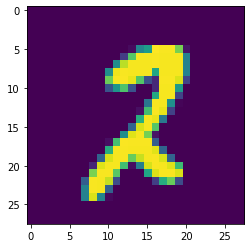

In [80]:
plt.imshow(img_x)
plt.show()

In [83]:
#checking for balance

In [84]:
total = 0
counter = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
for data in trainset:
    xs,ys = data
    for y in ys:
        counter[int(y)]+=1

In [85]:
counter

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

In [86]:
import torch.nn as nn
import torch.nn.functional as F


In [121]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        Note -
        # Weights are initialized ~ UNIFORM(-SQRT(K),SQRT(K)), K = 1/n_input_features
        # PARAMETERS i.e, weights in Linear layers have require_grad=True by default 
        & autograd detects it while performing backward() and gives derivative of output 
        wrt parameters
        '''
        self.layer1 = nn.Linear(28*28, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, 10)
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        
        return F.log_softmax(x,dim=1)
        
        

In [122]:
net = Net()
print(net)

Net(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=10, bias=True)
)


In [123]:
import torch.optim as optim
#net.parameters() - everything adjustable in model
optimizer = optim.Adam(net.parameters(),lr=0.001)
#epochs = a pass through whole data
EPOCHS = 4

for epochs in range(EPOCHS):
    for data in trainset:
        # data is a batch of featuresets and labels and batch size=10
        X,y  = data
        net.zero_grad()   #zero the gradient after batch is over
        output = net(X.view(-1,28*28))
        loss = F.nll_loss(output,y)           #negative likelihood loss
        #print("Loss="+str(loss))
        loss.backward()   # computes d(loss)/dparameter
        optimizer.step()
    print(loss)
        
        

tensor(0.1242, grad_fn=<NllLossBackward>)
tensor(0.0038, grad_fn=<NllLossBackward>)
tensor(0.1925, grad_fn=<NllLossBackward>)
tensor(0.0002, grad_fn=<NllLossBackward>)


#### viewing prameters

In [124]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.data)

layer1.weight tensor([[ 0.0247,  0.0268,  0.0049,  ...,  0.0031,  0.0227,  0.0066],
        [ 0.0111,  0.0065, -0.0315,  ...,  0.0212,  0.0343,  0.0003],
        [-0.0280,  0.0346,  0.0357,  ..., -0.0149, -0.0163,  0.0147],
        ...,
        [-0.0353, -0.0031, -0.0350,  ..., -0.0260, -0.0068,  0.0101],
        [ 0.0320, -0.0109, -0.0129,  ...,  0.0316, -0.0105,  0.0025],
        [-0.0283,  0.0298, -0.0016,  ...,  0.0161,  0.0176,  0.0174]])
layer1.bias tensor([-0.0221, -0.0953,  0.1431,  0.2258, -0.0369,  0.0642,  0.0212,  0.0158,
         0.0917,  0.0168,  0.2361, -0.0072,  0.0079,  0.0132, -0.0800,  0.1626,
        -0.0595, -0.0116, -0.0254,  0.0912,  0.0447, -0.0099,  0.0180,  0.1490,
        -0.0302, -0.0389, -0.0182, -0.0994, -0.0059, -0.0383, -0.0542,  0.1763,
         0.1112, -0.0625, -0.1228, -0.1412,  0.1001,  0.0652, -0.0652, -0.0758,
        -0.1176,  0.1359,  0.0722, -0.0880, -0.0438, -0.0264,  0.0468,  0.0100,
        -0.0388,  0.1565, -0.0920, -0.0118,  0.0116,  0.0300

In [125]:
correct = 0
total = 0

with torch.no_grad():   #do not calculate gradients , just give me forward pass and do the following
    for data in testset:
        X,y = data
        output = net(X.view(-1,28*28))
        for idx, i in enumerate(output):
            if torch.argmax(i) ==y[idx]:
                correct+=1
            total+=1
print("Accuracy = "+str(correct/total))
    
    
    

Accuracy = 0.9728


#### Convenience :  nn.Sequential

In [138]:
# Defining architecture of our network
input_size = 28*28
hidden = [128,128,128]
output = 10

# 784 -> 128 -> 128 -> 128 -> 10

model = nn.Sequential(nn.Linear(input_size,hidden[0]), 
                      nn.ReLU(),
                      nn.Linear(hidden[0],hidden[1]),
                     nn.ReLU(),
                      nn.Linear(hidden[1],hidden[2]),
                     nn.ReLU(),
                      nn.Linear(hidden[2],output),
                      nn.LogSoftmax(dim=1)
                     )

print(model)


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=10, bias=True)
  (7): LogSoftmax()
)


In [139]:
import torch.optim as optim
#net.parameters() - everything adjustable in model
optimizer = optim.Adam(model.parameters(),lr=0.001)
#epochs = a pass through whole data
EPOCHS = 4

for epochs in range(EPOCHS):
    for data in trainset:
        # data is a batch of featuresets and labels and batch size=10
        X,y  = data
        model.zero_grad()   #zero the gradient after batch is over
        output = model(X.view(-1,28*28))
        loss = F.nll_loss(output,y)           #negative likelihood loss
        #print("Loss="+str(loss))
        loss.backward()   # computes d(loss)/dparameter
        optimizer.step()
    print(loss)

tensor(0.0046, grad_fn=<NllLossBackward>)
tensor(0.0040, grad_fn=<NllLossBackward>)
tensor(0.1974, grad_fn=<NllLossBackward>)
tensor(0.0039, grad_fn=<NllLossBackward>)


In [140]:
correct = 0
total = 0

with torch.no_grad():   #do not calculate gradients , just give me forward pass and do the following
    for data in testset:
        X,y = data
        output = model(X.view(-1,28*28))
        for idx, i in enumerate(output):
            if torch.argmax(i) ==y[idx]:
                correct+=1
            total+=1
print("Accuracy = "+str(correct/total))

Accuracy = 0.9671
